In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pprint import pprint

import requests

from bs4 import BeautifulSoup

import json
import time
import copy
from collections import Counter
import re
import string

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as SKMultinomialNB
import unicodedata
from nltk.corpus import stopwords

In [2]:
corpus = pd.read_csv("data/booksummaries/summaries&genres.csv")
corpus['Summary'] = corpus['Summary'].str.lower()


In [3]:
y = corpus['scifi?'] #create targets

In [4]:
stemmer = SnowballStemmer('english')
corpus['Stemmed_Summary'] = corpus['Summary'].apply(lambda doc: [stemmer.stem(word) for word in word_tokenize(doc)])
corpus['Stemmed_Summary'] = corpus['Stemmed_Summary'].str.join(' ')

In [5]:
corpus['Stemmed_Summary'].str.replace('starship', 'spaceship')

0        old major , the old boar on the manor farm , c...
1        alex , a teenag live in near-futur england , l...
2        the text of the plagu is divid into five part ...
3        the novel posit that space around the milki wa...
4        the book tell the stori of paul bäumer , a ger...
                               ...                        
12836    the stori start with former govern agent , fra...
12837    the seri follow the charact of nick stone , an...
12838    the reader first meet rapp while he is do a co...
12839    the book follow veri rough chronolog order , w...
12840    makar devushkin and varvara dobroselova are se...
Name: Stemmed_Summary, Length: 12841, dtype: object

In [6]:
from nltk.corpus import stopwords
sw = stopwords.words('english') #setup stop words
sw.extend(['use','father','discover','three','third','one','two','late','confront','number','find','kill','take','also','people','begin','thing','first','planet','because','open','stuart','get','fill'])

tfidf_vec = TfidfVectorizer(stop_words=sw)
count_vec = CountVectorizer(stop_words=sw, max_features=1000)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y,stratify=y) #split data with all columns/info

In [8]:
rf = RandomForestClassifier(max_depth=1000, max_features = 10000, oob_score=True)

In [9]:
X_train_nlp = tfidf_vec.fit_transform(X_train['Stemmed_Summary'])
X_test_nlp = tfidf_vec.transform(X_test['Stemmed_Summary'])

In [10]:
rf.fit(X_train_nlp, y_train)

RandomForestClassifier(max_depth=1000, max_features=10000, oob_score=True)

In [11]:
TFIDF_train_score = rf.score(X_train_nlp, y_train)
TFIDF_test_score = rf.score(X_test_nlp, y_test)

print(TFIDF_train_score)
print(TFIDF_test_score)

0.9997923156801661
0.8726253503581439


Text(0.5, 0, 'Word Scores')

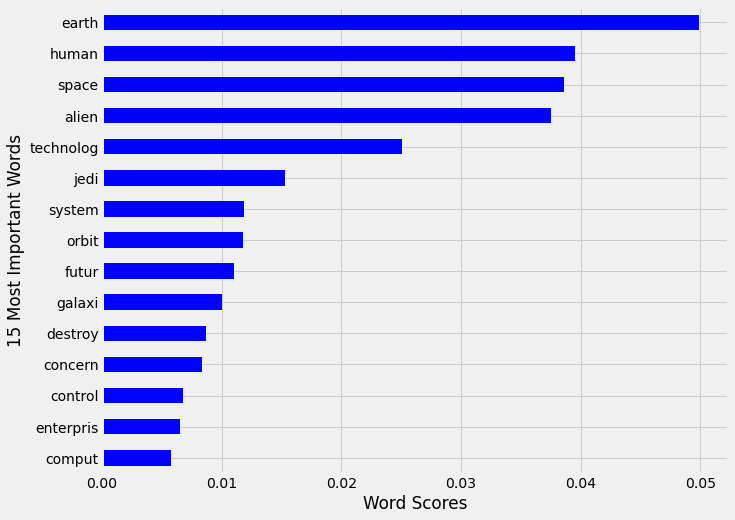

In [12]:
fig, ax = plt.subplots()
feat_scores = pd.Series(rf.feature_importances_, index=tfidf_vec.get_feature_names())
feat_scores = feat_scores.sort_values()
ax = feat_scores[-15:].plot(kind='barh',figsize=(10,8),color='b')
ax.set_ylabel('15 Most Important Words')
ax.set_xlabel('Word Scores')
# fig.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS3/images/words_final.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         metadata=None)

In [13]:
def predict(model, X, threshold):
    return np.where(model.predict_proba(X)[:,0]>threshold, model.classes_[0], model.classes_[1])

In [14]:
# function to create confusion matrix plot
import itertools
def plot_confusion_matrix(cm, # confusion matrix
                          classes_x, # test to describe what the output of the classes may be (commonly 1 or 0)
                          classes_y,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_x))
    plt.xticks(tick_marks, classes_x, rotation=45)
    plt.yticks(tick_marks, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
predictions = predict(rf, X_test_nlp, .50)
cf = pd.crosstab(y_test, predictions)
print(cf)

col_0   False  True 
scifi?              
False    2378    111
True      295    427


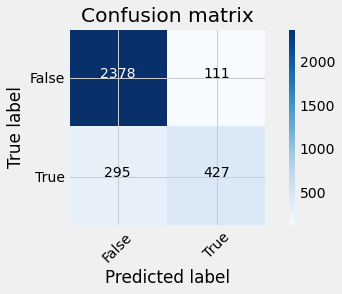

In [16]:
plot_confusion_matrix(cf.values, cf.index.values, cf.T.index.values)
# plt.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS3/images/final_confusion.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         metadata=None)

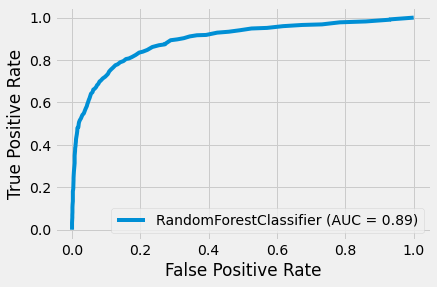

In [17]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf,X_test_nlp,y_test)

# plt.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS3/images/final_roc.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         metadata=None)

In [21]:
#misclassified results
mislabeled = X_test[y_test != predictions]

In [23]:
X2 = count_vec.fit_transform(mislabeled['Stemmed_Summary'])
count_df = pd.DataFrame(X2.toarray(),columns=count_vec.get_feature_names())

In [25]:
word_counts = count_df.sum(axis=0)
print(word_counts.sort_values(axis=0,ascending=False))
# Word count of mislabeled docs

time        361
world       339
new         318
return      301
becom       284
           ... 
karn         21
spi          21
briar        21
wear         21
particip     21
Length: 1000, dtype: int64
